In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from datetime import datetime
from zoneinfo import ZoneInfo 
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
import pandas as pd
import os

bucket = os.getenv("S3_BUCKET")
path1 = f"s3://{bucket}/price-financial-info/year=2025/month=9/market=kospi/2025-09-29.parquet"
path2 = f"s3://{bucket}/company-profile/year=2025/month=9/market=kospi/2025-09-29.parquet"

df1 = pd.read_parquet(path1, engine="fastparquet")
df2 = pd.read_parquet(path2, engine="fastparquet")

kospi_df = pd.concat([df1, df2], axis=1)
kospi_df.head()

,name,market,industry,close,change,change_rate,market_cap,BPS,PER,PBR,EPS,DIV,DPS,ROE,explanation
095570,AJ네트웍스,KOSPI,일반서비스,4310,35,0.82,195039391290,9902.0,8.89,0.44,485.0,6.26,270.0,0.048980,"동사는 2000년 OA기기 및 산업용 특수장비의 대여, 판매를 목적으로 설립되어 2..."
006840,AK홀딩스,KOSPI,기타금융,10590,210,2.02,140291670990,40295.0,0.00,0.26,0.0,3.78,400.0,0.000000,"동사는 2012년 인적분할로 지주회사로 전환되어 애경케미칼, 애경산업, 제주항공, ..."
027410,BGF,KOSPI,기타금융,3930,75,1.95,376166988630,18202.0,4.08,0.22,963.0,3.31,130.0,0.052906,동사는 1994년 설립되어 2017년 투자사업부문과 사업부문으로 분할 후 2018년...
282330,BGF리테일,KOSPI,유통,107900,1200,1.12,1864933457400,68546.0,9.55,1.57,11301.0,3.80,4100.0,0.164867,"동사는 2017년 비지에프에서 분할된 법인으로, 2025년 BGF RETAIL HA..."
138930,BNK금융지주,KOSPI,기타금융,14520,90,0.62,4565453236080,33604.0,6.68,0.43,2174.0,4.48,650.0,0.064695,"동사는 2011년 주식 포괄적 이전으로 설립된 지주회사이며, 부산은행, BNK투자증..."


In [ ]:
import polars as pl

bucket = os.getenv("S3_BUCKET")
prefix = 'price-financial-info'
market = 'kospi'

df_polars = pl.read_parquet(
    f"s3://{bucket}/{prefix}/**/market={market}/*.parquet",
    include_file_paths="file_path",
    hive_partitioning=False
)

df_with_date = df_polars.with_columns(
    pl.col("file_path")
      .str.split("/")
      .list.last()
      .str.replace(".parquet", "")
      .str.to_datetime()
      .alias("date")
).drop("file_path")

data_dict = {
    (date[0] if not hasattr(date, "item") else date.item()):
    (lambda pdf: (
        pdf.rename(columns={"__index_level_0__": "tickers"}).set_index("tickers")
        if "__index_level_0__" in pdf.columns else
        pdf.rename(columns={"index": "tickers"}).set_index("tickers")
        if "index" in pdf.columns else
        pdf.set_index("tickers") if "tickers" in pdf.columns else
        pdf
    ))(group.to_pandas())
    for date, group in df_with_date.group_by("date", maintain_order=True)
}

#날짜별 스냅샷이 s3에 저장되어 있기에 이걸 시계열 데이터로 바꾸려면 위와 같은 과정이 필요함.
#data_dict는 key에 날짜 item에 해당 날짜의 dataframe이 담겨있음.
data_dict[list(data_dict.keys())[0]]

,name,market,industry,close,change,change_rate,market_cap,BPS,PER,PBR,EPS,DIV,DPS,ROE,date
tickers,,,,,,,,,,,,,,,
095570,AJ네트웍스,KOSPI,일반서비스,5150,170,3.41,233051708850,8076.0,25.62,0.64,201.0,5.24,270.0,0.024889,2024-01-02
006840,AK홀딩스,KOSPI,기타금융,17090,-10,-0.06,226400817490,41948.0,0.00,0.41,0.0,1.17,200.0,0.000000,2024-01-02
027410,BGF,KOSPI,기타금융,3850,40,1.05,368509645350,16528.0,15.59,0.23,247.0,2.86,110.0,0.014944,2024-01-02
282330,BGF리테일,KOSPI,유통,135100,3800,2.89,2335055700600,55724.0,12.06,2.42,11203.0,3.03,4100.0,0.201044,2024-01-02
138930,BNK금융지주,KOSPI,기타금융,7010,-130,-1.82,2257839950380,30468.0,2.92,0.23,2404.0,8.92,625.0,0.078902,2024-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
079980,휴비스,KOSPI,화학,4150,30,0.73,143175000000,11585.0,0.00,0.36,0.0,0.00,0.0,0.000000,2024-01-02
005010,휴스틸,KOSPI,금속,4925,-60,-1.20,276726269375,16181.0,0.87,0.30,5675.0,7.11,350.0,0.350720,2024-01-02
000540,흥국화재,KOSPI,보험,3070,0,0.00,197224920150,11050.0,1.43,0.28,2142.0,0.00,0.0,0.193846,2024-01-02


In [3]:
def create_cross_section_df(ticker, data_dict):
    cross_sectional_data = {}
    for date, daily_df in data_dict.items():
        if ticker in daily_df.index:
            cross_sectional_data[date] = daily_df.loc[ticker]
    if not cross_sectional_data:
        print(f"'{ticker}'에 해당하는 데이터를 찾을 수 없습니다.")
        return pd.DataFrame()
    df = pd.DataFrame.from_dict(cross_sectional_data, orient='index')
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    return df

samsung = create_cross_section_df('005930', data_dict)
samsung

,name,market,industry,close,change,change_rate,market_cap,BPS,PER,PBR,EPS,DIV,DPS,ROE,date
2024-01-02,삼성전자,KOSPI,전기·전자,79600,1100,1.40,475194690980000,50817.0,9.88,1.57,8057.0,1.81,1444.0,0.158549,2024-01-02
2024-01-03,삼성전자,KOSPI,전기·전자,77000,-2600,-3.27,459673256350000,50817.0,9.56,1.52,8057.0,1.88,1444.0,0.158549,2024-01-03
2024-01-04,삼성전자,KOSPI,전기·전자,76600,-400,-0.52,457285343330000,50817.0,9.51,1.51,8057.0,1.89,1444.0,0.158549,2024-01-04
2024-01-05,삼성전자,KOSPI,전기·전자,76600,0,0.00,457285343330000,50817.0,9.51,1.51,8057.0,1.89,1444.0,0.158549,2024-01-05
2024-01-08,삼성전자,KOSPI,전기·전자,76500,-100,-0.13,456688365075000,50817.0,9.49,1.51,8057.0,1.89,1444.0,0.158549,2024-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-23,삼성전자,KOSPI,전기·전자,84700,1200,1.44,501393331993400,57951.0,17.11,1.46,4950.0,1.71,1446.0,0.085417,2025-09-23
2025-09-24,삼성전자,KOSPI,전기·전자,85400,700,0.83,505537078538800,57951.0,17.25,1.47,4950.0,1.69,1446.0,0.085417,2025-09-24
2025-09-25,삼성전자,KOSPI,전기·전자,86100,700,0.82,509680825084200,57951.0,17.39,1.49,4950.0,1.68,1446.0,0.085417,2025-09-25
2025-09-26,삼성전자,KOSPI,전기·전자,83300,-2800,-3.25,493105838902600,57951.0,16.83,1.44,4950.0,1.74,1446.0,0.085417,2025-09-26


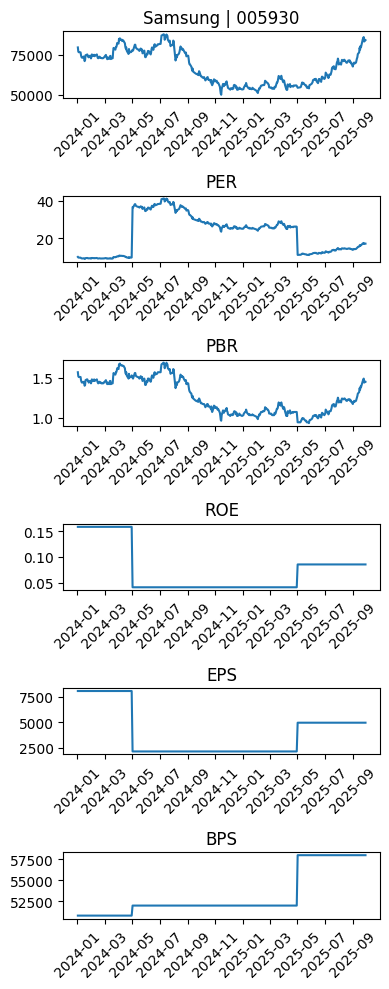

In [4]:
plt.figure(figsize=[4,10])

plt.subplot(6,1,1)
plt.title('Samsung | 005930')
plt.plot(samsung['close'])
plt.xticks(rotation=45)

plt.subplot(6,1,2)
plt.title('PER')
plt.plot(samsung['PER'])
plt.xticks(rotation=45)

plt.subplot(6,1,3)
plt.title('PBR')
plt.plot(samsung['PBR'])
plt.xticks(rotation=45)

plt.subplot(6,1,4)
plt.title('ROE')
plt.plot(samsung['ROE'])
plt.xticks(rotation=45)

plt.subplot(6,1,5)
plt.title('EPS')
plt.plot(samsung['EPS'])
plt.xticks(rotation=45)

plt.subplot(6,1,6)
plt.title('BPS')
plt.plot(samsung['BPS'])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()